This is me just tinkering with stuff. Go to the original Final Models notebook for the real code.

# Preprocessing

In [47]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from scipy.interpolate import interp1d

In [48]:
codes_states = [('AK', 'Alaska'), ('AL', 'Alabama'), ('AZ', 'Arizona'), ('AR', 'Arkansas'), ('CA', 'California'), ('CO', 'Colorado'), ('CT', 'Connecticut'), ('DE', 'Delaware'), ('FL', 'Florida'), ('GA', 'Georgia'), ('HI', 'Hawaii'), ('ID', 'Idaho'), ('IL', 'Illinois'), ('IN', 'Indiana'), ('IA', 'Iowa'), ('KS', 'Kansas'), ('KY', 'Kentucky'), ('LA', 'Louisiana'), ('ME', 'Maine'), ('MD', 'Maryland'), ('MA', 'Massachusetts'), ('MI', 'Michigan'), ('MN', 'Minnesota'), ('MS', 'Mississippi'), ('MO', 'Missouri'), ('MT', 'Montana'), ('NE', 'Nebraska'), ('NV', 'Nevada'), ('NH', 'New Hampshire'), ('NJ', 'New Jersey'), ('NM', 'New Mexico'), ('NY', 'New York State'), ('NC', 'North Carolina'), ('ND', 'North Dakota'), ('OH', 'Ohio'), ('OK', 'Oklahoma'), ('OR', 'Oregon'), ('PA', 'Pennsylvania'), ('RI', 'Rhode Island'), ('SC', 'South Carolina'), ('SD', 'South Dakota'), ('TN', 'Tennessee'), ('TX', 'Texas'), ('UT', 'Utah'), ('VT', 'Vermont'), ('VA', 'Virginia'), ('WA', 'Washington'), ('WV', 'West Virginia'), ('WI', 'Wisconsin'), ('WY', 'Wyoming')]
codes = [a for a, _ in codes_states] + ['USA']
names = [b for _, b in codes_states] + ['USA']
to_name = dict(codes_states)
to_code = dict([(b, a) for a, b in codes_states])

In [49]:
# helpers

def date_to_day(string):
    v1 = datetime.strptime(string, "%Y-%m-%d")
    v2 = date(v1.year, v1.month, v1.day)
    v3 = (v2 - date(v2.year, 1, 1)).days + 1
    if v2.year == 2020:
        v3 = v3 - 365
    return v3

def dates_to_days(series):
    lst = series.to_numpy()
    days = [date_to_day(v) for v in lst]
    df = pd.DataFrame(data=days, columns=['day'])
    return df

def fill_missing(x, y):
    new_x, new_y = [], []
    for i in range(0, len(x)):

        if not new_y:
            if np.isnan(y[i]):
                continue
            if i == len(y):
                return None
            for j in range(i+1):
                new_x.append(x[j])
                new_y.append(y[i])
            continue
        
        while new_x[-1] < x[i] - 1:
            new_x.append(new_x[-1] + 1)
            new_y.append(new_y[-1])
        new_x.append(x[i])
        if np.isnan(y[i]):
            new_y.append(new_y[-1])
        else:
            new_y.append(y[i])
    return new_x, new_y

def interpolate(y):
    update_idxs = [0]
    for i in range(1, len(y)):
        if y[i] != y[update_idxs[-1]]:
            update_idxs.append(i)
    update_idxs[-1] = len(y) - 1
    f = interp1d(update_idxs, np.array(y)[update_idxs])
    new_y = list(f(list(range(len(y)))))
    return new_y

## Vaccinations

In [50]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
raw_df['day'] = dates_to_days(raw_df['date'])
df = raw_df[['day', 'location', 'people_fully_vaccinated_per_hundred', 'people_fully_vaccinated']]
df = df.rename(columns={'location' : 'loc', 'people_fully_vaccinated_per_hundred' : 'vacc_per_100'})

df_per_state = {}
for name in names:
    if name == 'USA':
        continue
    df_per_state[name] = df[df['loc'] == name][['day', 'vacc_per_100', 'people_fully_vaccinated']]
    df_per_state[name] = df_per_state[name].reset_index(drop=True)

vacc_dct = {}
for name, state_df in df_per_state.items():
    raw_days = state_df['day'].to_numpy()
    raw_vacc = state_df['vacc_per_100'].to_numpy()
    raw_total = state_df['people_fully_vaccinated'].to_numpy()
    
    val = fill_missing(raw_days, raw_vacc)
    if val is None:
        continue
    days, vacc = val
    interpolated = interpolate(vacc)
    
    val = fill_missing(raw_days, raw_total)
    if val is None:
        continue
    _, total = val

    vacc_dct[to_code[name]] = {'day' : days, 'vacc' : vacc, 'interp' : interpolated, 'total' : total}

days = vacc_dct['AK']['day']
total = np.zeros(len(days))
for code in vacc_dct:
    total += vacc_dct[code]['total']
vacc = total / (328.2 * 1000000) * 100

vacc_dct['USA'] = {'day' : days, 'vacc' : vacc, 'interp' : vacc, 'total' : total}

## Variants

In [51]:
with open('outbreak_combined_us_state_data.json') as json_file:
    raw_dct = json.load(json_file)

with open('outbreak_us.json') as json_file:
    raw_dct += json.load(json_file)

variants_dct = {}
for i in range(len(raw_dct)):
    if 'label' not in raw_dct[i]:
        continue
    if raw_dct[i]['label'] not in variants_dct:
        variants_dct[raw_dct[i]['label']] = {}
    days, prop = [], []
    for point in raw_dct[i]['data']:
        days.append(date_to_day(point['date']))
        prop.append(point['proportion'])
    if days:
        days, prop = fill_missing(days, prop)
        interpolated = interpolate(prop)
    # only want days after we have vaccination data
    if days and days[0] < 12:
        idx = days.index(12)
        days = days[idx:]
        prop = prop[idx:]
        interpolated = interpolated[idx:]
    dct = {'day' : days, 'prop' : prop, 'interp' : interpolated}
    name = raw_dct[i]['route']['selected'][7:]
    if name == '':
        name = raw_dct[i]['route']['selected']
    variants_dct[raw_dct[i]['label']][name] = dct
# print(variants_dct['P.1']['USA'])

# Models

In [52]:
# Universal Model Parameters

days_ahead = 10
lag_order = 14

# data from last ~two weeks has not been finalized

end_test = -14

# LSTM

## Time Series

In [118]:
test_points_per_state = 3
end_test_input = end_test - days_ahead
end_train_input = end_test_input - lag_order - (test_points_per_state - 1)

min_train_points_per_state = 5
# Ask about this?
min_start_train = end_train_input - (lag_order - 1) - (min_train_points_per_state - 1)

def input_output(days, prop, vacc, code, first_start_idx, last_start_idx):
    state = [0 for _ in range(len(codes))]
    state[codes.index(code)] = 1
    x, y = [], []
    for i in range(first_start_idx, last_start_idx):
        x_point = []
        for j in range(i, i + lag_order):
            x_point.append(state + [days[j], vacc[j], prop[j]])
        x.append(x_point)
        y.append(prop[j + days_ahead])
    return x, y

X_train, Y_train = {}, {}
X_test, Y_test = {}, {}

for variant in variants_dct: 
    
    X_train[variant], Y_train[variant] = {'all' : []}, {'all' : []}
    X_test[variant], Y_test[variant] = {'all' : []}, {'all' : []}
    
    for code in variants_dct[variant]:
        days = variants_dct[variant][code]['day']
        
        if not days or days[0] >= days[-1] + min_start_train:
            continue
        
        prop = variants_dct[variant][code]['interp']

        i1 = vacc_dct[code]['day'].index(days[0])

        # variant data lags behind, so vacc is longer than prop most of the time
        # so don't be alarmed if you notice this to be the case
        vacc = vacc_dct[code]['interp'][i1:]
        
        first_start_idx = 0
        last_start_idx = len(days) + end_train_input - lag_order
        x, y = input_output(days, prop, vacc, code, first_start_idx, last_start_idx)
        X_train[variant][code], Y_train[variant][code] = x, y
        X_train[variant]['all'] += x
        Y_train[variant]['all'] += y

        first_start_idx = len(days) + end_train_input
        last_start_idx = first_start_idx + test_points_per_state
        x, y = input_output(days, prop, vacc, code, first_start_idx, last_start_idx)
        X_test[variant][code], Y_test[variant][code] = x, y
        X_test[variant]['all'] += x
        Y_test[variant]['all'] += y

## Train

In [119]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import keras

models = {}

for variant in X_train:
    x, y = np.array(X_train[variant]['all']), np.array(Y_train[variant]['all'])
    model = Sequential()
    ################ Added dropout here
    model.add(LSTM(6, activation='relu', recurrent_dropout=0.1, return_sequences=True, input_shape=(lag_order, 54)))
    model.add(LSTM(3, activation='relu', input_shape=(lag_order, 54)))
    model.add(Dense(1))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='mse')
    model.fit(x, y, epochs=20, validation_split=0.1, verbose=1)
    models[variant] = model

Epoch 1/20
78/78 [==============================] - 6s 28ms/step - loss: 0.0783 - val_loss: 0.0169
Epoch 2/20
78/78 [==============================] - 1s 14ms/step - loss: 0.0339 - val_loss: 0.0153
Epoch 3/20
78/78 [==============================] - 1s 15ms/step - loss: 0.0240 - val_loss: 0.0088
Epoch 4/20
78/78 [==============================] - 1s 14ms/step - loss: 0.0204 - val_loss: 0.0078
Epoch 5/20
78/78 [==============================] - 1s 14ms/step - loss: 0.0155 - val_loss: 0.0082
Epoch 6/20
78/78 [==============================] - 1s 15ms/step - loss: 0.0125 - val_loss: 0.0070
Epoch 7/20
78/78 [==============================] - 1s 14ms/step - loss: 0.0114 - val_loss: 0.0064
Epoch 8/20
78/78 [==============================] - 1s 14ms/step - loss: 0.0105 - val_loss: 0.0067
Epoch 9/20
78/78 [==============================] - 1s 14ms/step - loss: 0.0097 - val_loss: 0.0069
Epoch 10/20
78/78 [==============================] - 1s 14ms/step - loss: 0.0092 - val_loss: 0.0062
Epoch 11/

## Evaluate

In [55]:
thresh = 70

scores = {}

for variant in models:
    scores[variant] = {}
    scores[variant]['mae'] = 0
    scores[variant]['mse'] = 0
    n_states = 0
    for code in X_test[variant]:
        if code == 'all':
            continue
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        pred = models[variant].predict(X_test[variant][code])
        scores[variant]['mae'] += sum([abs(pred[i][0] - Y_test[variant][code][i]) for i in range(test_points_per_state)])
        scores[variant]['mse'] += sum([(pred[i][0] - Y_test[variant][code][i]) ** 2 for i in range(test_points_per_state)])
    scores[variant]['mae'] /= test_points_per_state * n_states
    scores[variant]['mse'] /= test_points_per_state * n_states

print(scores)

{'B.1.1.7': {'mae': 0.13340799281326543, 'mse': 0.02584464278914607}, 'B.1.351': {'mae': 0.007220025825988066, 'mse': 9.980422668621954e-05}, 'P.1': {'mae': 0.06346253721616238, 'mse': 0.010394575363157814}, 'B.1.427': {'mae': 0.015647593576493816, 'mse': 0.000847458149888035}, 'B.1.429': {'mae': 0.07594606567748337, 'mse': 0.006621906598343844}}


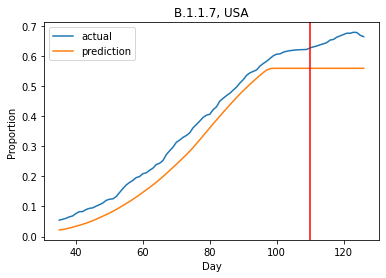

In [56]:
variant, code = 'B.1.1.7', 'USA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]

first_start_idx = 0
last_start_idx = len(days) + end_train_input + 3
input, actual = input_output(days, prop, vacc, code, first_start_idx, last_start_idx)
pred = models[variant].predict(input)

n = lag_order + days_ahead - 1
plt.plot([d for d in days[n:end_test]], actual, label='actual')
plt.plot([d for d in days[n:end_test]], pred, label='prediction')
plt.axvline(x=days[-1] + end_train_input + days_ahead, color='r')
plt.xlabel('Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

# VAR

## Time Series

In [57]:
test_points_per_state = 3

def train_test(code, variant, n=test_points_per_state):
    days = variants_dct[variant][code]['day']
    prop = variants_dct[variant][code]['interp']
    
    i1 = vacc_dct[code]['day'].index(days[0])
    vacc = vacc_dct[code]['interp'][i1:]
    vacc = vacc[:len(days)]

    i2 = end_test - days_ahead - n
    train = np.array([days[:i2], vacc[:i2], prop[:i2]]).T
    test = np.array([days[i2:end_test], vacc[i2:end_test], prop[i2:end_test]]).T

    return train, test

## Train

In [58]:
from statsmodels.tsa.api import VAR

def trained_model(code, variant, n=test_points_per_state):
    train, _ = train_test(code, variant, n=n)
    model = VAR(train)
    smallest, largest = 2, 6
    lag_orders = list(range(smallest, largest + 1))
    aic_scores = [model.fit(i).aic for i in lag_orders]
    lag = np.argmin(aic_scores) + smallest
    model = model.fit(lag)
    return model

## Evaluate

In [59]:
thresh = 70

scores = {}

for variant in variants_dct:
    scores[variant] = {}
    scores[variant]['mae'] = 0
    scores[variant]['mse'] = 0
    n_states = 0
    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        model = trained_model(code, variant)
        train, test = train_test(code, variant)
        pred = model.forecast(y=train, steps=days_ahead+test_points_per_state)
        scores[variant]['mae'] += sum([abs(pred[i][2] - test[i][2]) for i in range(days_ahead, days_ahead+test_points_per_state)])
        scores[variant]['mse'] += sum([(pred[i][2] - test[i][2]) ** 2 for i in range(days_ahead, days_ahead+test_points_per_state)])
    scores[variant]['mae'] /= test_points_per_state * n_states
    scores[variant]['mse'] /= test_points_per_state * n_states

print(scores)

{'B.1.1.7': {'mae': 0.13378863825127182, 'mse': 0.029183701983198265}, 'B.1.351': {'mae': 0.007374578440442264, 'mse': 0.0001233550313869424}, 'P.1': {'mae': 0.023766323737252345, 'mse': 0.001029839355474237}, 'B.1.427': {'mae': 0.0298648965636486, 'mse': 0.0035611816692715558}, 'B.1.429': {'mae': 0.04875291849097428, 'mse': 0.005970261201874699}}


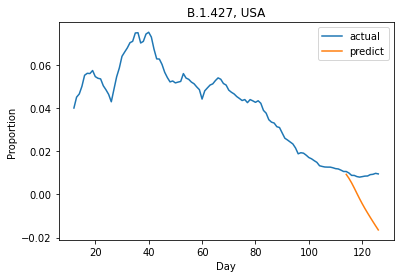

In [60]:
variant, code = 'B.1.427', 'USA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]

plt.plot(days[:end_test], prop[:end_test], label='actual')

model = trained_model(code, variant)
train, test = train_test(code, variant)
pred = model.forecast(y=train, steps=days_ahead+test_points_per_state)

plt.plot(test[:, 0], pred[:, 2], label='predict')

plt.legend()
plt.xlabel('Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.show()

# Ensemble

In [61]:
class Ensemble():
    
    def __init__(self, code, lstm, var):
        self.lstm = lstm
        self.var = var
        self.code = code

    def predict(self, days, vacc, prop):
        one_hot = [0 for _ in codes]
        one_hot[codes.index(self.code)] = 1
        lstm_input = []
        for i in range(lag_order):
            pt = one_hot + [days[-lag_order+i], vacc[-lag_order+i], prop[-lag_order+i]]
            lstm_input.append(pt)
        lstm_input = np.array([lstm_input])
        pred1 = self.lstm.predict(lstm_input)[0][0]

        var_input = np.array([days, vacc, prop]).T
        pred2 = self.var.forecast(y=var_input, steps=days_ahead)[-1][2]

        return (pred1 + pred2) / 2

## Evaluate

In [120]:
thresh = 70
test_points_per_state = 3

scores = {}

for variant in variants_dct:
    scores[variant] = {}
    scores[variant]['mae'] = 0
    scores[variant]['mse'] = 0
    
    n_states = 0 
    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        ensemble = Ensemble(code, models[variant], trained_model(code, variant))

        train, test = train_test(code, variant, n=test_points_per_state)
        
        days = variants_dct[variant][code]['day']
        prop = variants_dct[variant][code]['interp']
        i1 = vacc_dct[code]['day'].index(days[0])
        vacc = vacc_dct[code]['interp'][i1:]
        vacc = vacc[:len(days)]

        first_end_idx = end_test - days_ahead - test_points_per_state

        for i in range(test_points_per_state):
            i_days, i_prop, i_vacc = days[:first_end_idx+i], prop[:first_end_idx+i], vacc[:first_end_idx+i]
            pred = ensemble.predict(i_days, i_vacc, i_prop)
            test = prop[first_end_idx+i+days_ahead]
            scores[variant]['mae'] += abs(pred - test)
            scores[variant]['mse'] += (pred - test) ** 2
    
    scores[variant]['mae'] /= test_points_per_state * n_states
    scores[variant]['mse'] /= test_points_per_state * n_states

print(scores)

{'B.1.1.7': {'mae': 0.08730486050859737, 'mse': 0.012274462112607906}, 'B.1.351': {'mae': 0.004792784803942914, 'mse': 3.666639608444312e-05}, 'P.1': {'mae': 0.03391308813228922, 'mse': 0.003012789953111132}, 'B.1.427': {'mae': 0.022472351671475085, 'mse': 0.0013004908696221484}, 'B.1.429': {'mae': 0.04266797557363612, 'mse': 0.0024636408057167563}}


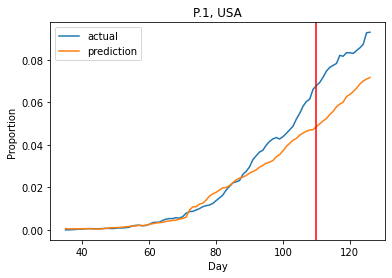

In [121]:
variant, code = 'P.1', 'USA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in days[n:end_test]], prop[n:end_test], label='actual')
plt.plot([d for d in days[n:end_test]], pred, label='prediction')
plt.axvline(x=days[-1] + end_train_input + days_ahead, color='r')
plt.xlabel('Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

# Interpretation

## Actual vs. Predicted Correlation

In [64]:
thresh = 50
test_points_per_state = 3

import collections
actual = collections.defaultdict(list)
predicted = collections.defaultdict(list)

for variant in variants_dct:
    
    n_states = 0 
    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        ensemble = Ensemble(code, models[variant], trained_model(code, variant))

        train, test = train_test(code, variant, n=test_points_per_state)
        
        days = variants_dct[variant][code]['day']
        prop = variants_dct[variant][code]['interp']
        i1 = vacc_dct[code]['day'].index(days[0])
        vacc = vacc_dct[code]['interp'][i1:]
        vacc = vacc[:len(days)]

        first_end_idx = end_test - days_ahead - test_points_per_state

        for i in range(test_points_per_state):
            i_days, i_prop, i_vacc = days[:first_end_idx+i], prop[:first_end_idx+i], vacc[:first_end_idx+i]
            pred = ensemble.predict(i_days, i_vacc, i_prop)
            test = prop[first_end_idx+i+days_ahead]
            actual[variant].append(test)
            predicted[variant].append(pred)

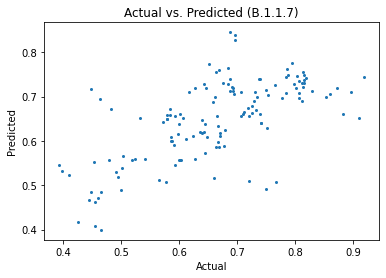

0.4375230142194011


In [65]:
code = 'B.1.1.7'
act = actual[code]
pre = predicted[code]

act_std = np.std(act)
pre_std = np.std(pre)

act_l = np.mean(act) - 2 * act_std
act_h = np.mean(act) + 2 * act_std

pre_l = np.mean(pre) - 2 * pre_std
pre_h = np.mean(pre) + 2 * pre_std

drop_act = []
drop_pre = []

for i in range(len(act)):
  if act_l <= act[i] <= act_h and pre_l <= pre[i] <= pre_h:
    drop_act.append(act[i])
    drop_pre.append(pre[i])

plt.scatter(drop_act, drop_pre, s=4)
plt.title("Actual vs. Predicted (" + code + ")")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

correlation_matrix = np.corrcoef(drop_act, drop_pre)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(r_squared)

## Look at Errors

In [128]:
thresh = 60
test_points_per_state = 3

import collections
mae_errors = collections.defaultdict(dict)
mse_errors = collections.defaultdict(dict)


for variant in variants_dct:
    
    n_states = 0 
    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        ensemble = Ensemble(code, models[variant], trained_model(code, variant))

        train, test = train_test(code, variant, n=test_points_per_state)
        
        days = variants_dct[variant][code]['day']
        prop = variants_dct[variant][code]['interp']
        i1 = vacc_dct[code]['day'].index(days[0])
        vacc = vacc_dct[code]['interp'][i1:]
        vacc = vacc[:len(days)]

        first_end_idx = end_test - days_ahead - test_points_per_state
        MAE = 0
        MSE = 0
        for i in range(test_points_per_state):
            i_days, i_prop, i_vacc = days[:first_end_idx+i], prop[:first_end_idx+i], vacc[:first_end_idx+i]
            pred = ensemble.predict(i_days, i_vacc, i_prop)
            test = prop[first_end_idx+i+days_ahead]
            MAE += abs(pred - test)
            MSE += (pred - test) ** 2
        mae_errors[variant][code] = MAE / test_points_per_state
        mse_errors[variant][code] = MSE / test_points_per_state


In [123]:
# Gives a general ratio to help contextualize MAE
code = 'B.1.1.7'
maes = [(k, mae_errors[code][k]) for k in mae_errors[code]]
rem = []
for i in maes:
    if i[0] == 'USA':
        continue
    else:
        rem.append(i)
print(rem)

[('AL', 0.050251917493593035), ('AK', 0.01783171131675802), ('AZ', 0.03714007637003188), ('CA', 0.009790174011117037), ('CO', 0.19075658980274754), ('CT', 0.03254038254464664), ('DE', 0.06389902380209896), ('FL', 0.14302776981533316), ('GA', 0.02959173180178598), ('HI', 0.11628933402282038), ('ID', 0.1719229237454267), ('IL', 0.09695274357620191), ('IN', 0.008407428033759231), ('IA', 0.07285350288055843), ('KS', 0.18793636288288332), ('KY', 0.04159334285578268), ('LA', 0.0830452785092735), ('ME', 0.05899525118772538), ('MD', 0.11713660325752999), ('MA', 0.11578859426248889), ('MI', 0.10818642392196558), ('MN', 0.10172373660061929), ('MO', 0.05556649671672098), ('MT', 0.03487982659166564), ('NE', 0.0945260165769694), ('NV', 0.024412864384465327), ('NH', 0.019106327216075174), ('NJ', 0.07070024613856213), ('NM', 0.19469689325375908), ('NY', 0.0768387604892362), ('NC', 0.09854787339000852), ('ND', 0.09788321978046928), ('OH', 0.2570929716857469), ('OK', 0.0960575141090075), ('OR', 0.01890

In [124]:
import plotly.express as px

df = pd.DataFrame.from_dict(rem)
df = df.rename(columns={0: "State", 1: "MAE"})

fig = px.choropleth(df, locations="State", locationmode="USA-states", scope='usa',
                    color="MAE",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = code)
fig.show()

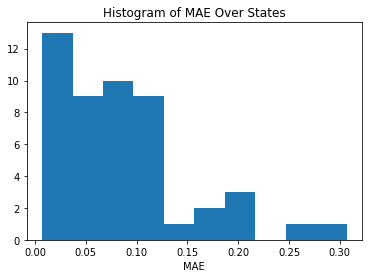

In [139]:
maes = [mae_errors['B.1.1.7'][k] for k in mae_errors['B.1.1.7']]

plt.hist(maes)
plt.xlabel("MAE")
plt.title("Histogram of MAE Over States")
plt.show()

Make sure gisaid_monthly_submit.csv is uploaded

In [153]:
df = pd.read_csv('gisaid_monthly_submit.csv')
df["State"] = df["Unnamed: 0"]

code = 'B.1.1.7'

total_reports = []
report_d = {}
for index, row in df.iterrows():
    if row['State'] not in to_code and row['State'] != "New York":
        continue
    elif row['State'] == "New York":
        state = 'NY'
    else:
        state = to_code[row['State']]
    total = row['country_total']
    total_reports.append((state, total / 1000))
    report_d[state] = total / 1000

df = pd.DataFrame.from_dict(total_reports)
df = df.rename(columns={0: "State", 1: "Reports"})

fig = px.choropleth(df, locations="State", locationmode="USA-states", scope='usa',
                    color="Reports",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = code)
fig.show()


In [173]:
high = []
low = []

for state, error in rem:
    if error >= 0.08:
        high.append(report_d[state])
    else:
        low.append(report_d[state])
print(high)
print(low)

print(np.mean(high))
print(np.mean(low))

[10.389, 29.863, 2.191, 1.114, 15.809, 2.813, 4.906, 11.435, 17.015, 25.213, 20.2, 1.855, 4.887, 8.849, 1.439, 7.336, 0.669, 13.623, 3.275, 0.555, 8.446, 8.554, 13.605, 7.24]
[2.665, 1.739, 16.395, 56.269, 7.086, 1.76, 6.892, 5.704, 0.905, 1.809, 3.374, 2.94, 0.686, 3.847, 1.93, 12.417, 41.297, 7.152, 2.749, 3.874, 56.415, 0.985, 21.598, 4.772]
9.220041666666665
11.0525


## Cross-Correlation

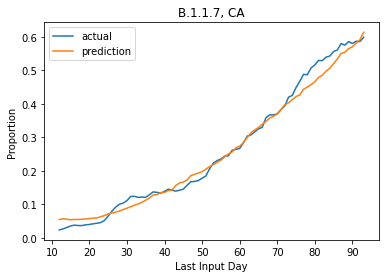

In [180]:
# input days vs prop

variant, code = 'B.1.1.7', 'CA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = vacc[:len(days)]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in days[:end_test-n]], prop[n:end_test], label='actual')
plt.plot([d for d in days[:end_test-n]], pred, label='prediction')
plt.xlabel('Last Input Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

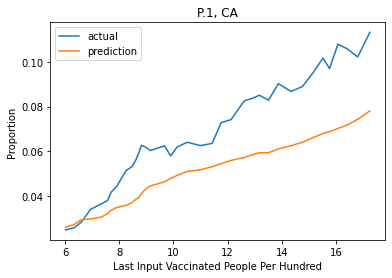

In [178]:
# input vacc vs prop

variant, code = 'B.1.1.7', 'CA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = vacc[:len(days)]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in vacc[:end_test-n]], prop[n:end_test], label='actual')
plt.plot([d for d in vacc[:end_test-n]], pred, label='prediction')
plt.xlabel('Last Input Vaccinated People Per Hundred')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

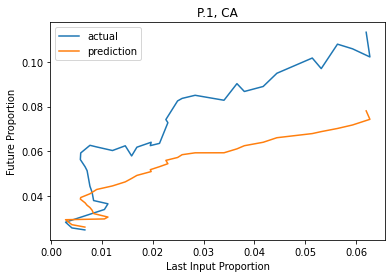

In [179]:
# input prop vs prop

variant, code = 'B.1.1.7', 'CA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = vacc[:len(days)]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in prop[:end_test-n]], prop[n:end_test], label='actual')
plt.plot([d for d in prop[:end_test-n]], pred, label='prediction')
plt.xlabel('Last Input Proportion')
plt.ylabel('Future Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()